Code is based on https://github.com/jhuggins/viabel

In [1]:
import pickle
import pystan
import autograd.numpy as np

from viabel.objectives import (black_box_klvi,
                               black_box_chivi)

from viabel.family import (mean_field_gaussian_variational_family,
                           mean_field_t_variational_family,
                           t_variational_family)

from viabel.models import make_stan_log_density
from viabel.optimization import adagrad_optimize
from experiments import (plot_dist_to_opt_param,
                         check_approx_accuracy,
                         psis_correction)

import pandas as pd

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tools\_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


Define the model

In [2]:
test_model = """data {
  int<lower=0> N;   // number of observations
  int <lower=0> D;  // number of predictors
  matrix[N, D] x;   // predictor matrix
  vector[N] y;      // outcome vector
}

parameters {
  vector[D] beta;        // coefficients for predictors
  real <lower=0> sigma;  // variance
}

model {
   beta ~ normal(0,1);
   sigma ~ gamma(0.5,0.5);
   y ~ normal(x * beta, sigma);
}"""

Generate of open existing a pkl file of the model

In [3]:
compiled_model_file = 'blr_reg_model.pkl'

try:
    with open(compiled_model_file, 'rb') as f:
        regression_model = pickle.load(f)
except:
    regression_model = pystan.StanModel(model_code=test_model,
                                        model_name='regression_model')
    with open('blr_reg_model.pkl', 'wb') as f:
        pickle.dump(regression_model, f)

Get data

In [4]:
# SYNTHETIC
# np.random.seed(1234)

# N = 1000
# D = 10
# beta_gen = np.random.randn(D, 1)
# sigma_gen = np.random.gamma(1, 1, 1)

# x = np.random.randn(N, D)
# y_raw = x.dot(beta_gen) + np.random.randn(N, 1)*np.sqrt(sigma_gen)
# y = y_raw - np.mean(y_raw)
# # convert from Nx1 matrix to Nx1 vector
# y = y.flatten()

In [5]:
#print(beta_gen)

In [6]:
#print(sigma_gen)

Import the dataset

In [7]:
data = pd.read_csv("bodyfat.csv").drop("Density", axis=1)
data = data - data.mean()
data.head(3)

,Bodyfat,Age,Weight,Height,Neck,Chest,Abdomen,Hip,Thigh,Knee,Ankle,Biceps,Forearm,Wrist
0,-6.850794,-21.884921,-24.674405,-2.39881,-1.792063,-7.724206,-7.355952,-5.404762,-0.405952,-1.290476,-1.202381,-0.273413,-1.263889,-1.129762
1,-13.050794,-22.884921,-5.674405,2.10119,0.507937,-7.224206,-9.555952,-1.204762,-0.705952,-1.290476,0.297619,-1.773413,0.236111,-0.029762
2,6.149206,-22.884921,-24.924405,-3.89881,-3.992063,-5.024206,-4.655952,-0.704762,0.194048,0.309524,0.897619,-3.473413,-3.463889,-1.629762


In [8]:
y = data["Bodyfat"].values
x = data.drop("Bodyfat", axis=1)

N = x.shape[0]
D = x.shape[1]

First, generate ground-truth posterior samples using Stan's dynamic HMC implementation:

In [9]:
data = dict(N=N, D=D, x=x, y=y)
fit = regression_model.sampling(data=data, iter=50000, thin=50, chains=10)

In [10]:
true_beta_mean = np.mean(fit['beta'], axis=0)
true_beta_cov = np.cov(fit['beta'].T)
print('true beta mean =', true_beta_mean)
print('true beta cov =', true_beta_cov)

true beta mean = [ 0.05452795 -0.09413561 -0.07661085 -0.48340438 -0.01934081  0.95485237
 -0.20189439  0.23813675  0.00951246  0.12780855  0.17502102  0.41102119
 -1.26681957]
true beta cov = [[ 9.89041391e-04  3.57685119e-04  2.93973698e-04 -9.18251947e-04
  -7.29365622e-05 -1.28114706e-03  3.42715185e-04  1.61907218e-03
  -1.89373717e-03  5.81102273e-04 -3.54964039e-04  8.08287985e-04
  -4.28585078e-03]
 [ 3.57685119e-04  2.75381255e-03 -2.25794201e-03 -3.49896979e-03
  -2.16088266e-03 -9.15920314e-04 -4.01499438e-03 -5.35905179e-04
  -3.18014456e-03 -1.89385504e-03 -1.50824983e-03 -9.93433882e-05
  -3.50544398e-03]
 [ 2.93973698e-04 -2.25794201e-03  8.63911574e-03  1.17349700e-04
   1.92765798e-03  1.08049774e-03  3.40205369e-03  2.46133891e-03
  -1.58143025e-03  1.12620589e-03  7.59084492e-04  5.51301729e-04
  -3.98076161e-03]
 [-9.18251947e-04 -3.49896979e-03  1.17349700e-04  4.98074501e-02
  -7.06990435e-04 -3.09234780e-04  5.81133450e-03 -3.62276145e-03
   7.48732497e-03  3.279

In [11]:
true_sigma_mean = np.mean(fit['sigma'], axis=0)
true_sigma_cov = np.cov(fit['sigma'].T)
print('true sigma mean =', true_sigma_mean)
print('true sigma cov =', true_sigma_cov)

true sigma mean = 4.28996509602803
true sigma cov = 0.0386637083449394


In [12]:
vec1 = fit['beta']
vec2 = np.array(fit['sigma'])
vec = []
for i in range(len(vec1)):
    temp = list(np.append(vec1[i], vec2[i]))
    vec.append(temp)
vec = np.array(vec)

In [13]:
true_mean = np.mean(vec, axis=0)
true_cov = np.cov(vec.T)

In [14]:
print('true mean =', true_mean)
print('true cov =', true_cov)

true mean = [ 0.05452795 -0.09413561 -0.07661085 -0.48340438 -0.01934081  0.95485237
 -0.20189439  0.23813675  0.00951246  0.12780855  0.17502102  0.41102119
 -1.26681957  4.2899651 ]
true cov = [[ 9.89041391e-04  3.57685119e-04  2.93973698e-04 -9.18251947e-04
  -7.29365622e-05 -1.28114706e-03  3.42715185e-04  1.61907218e-03
  -1.89373717e-03  5.81102273e-04 -3.54964039e-04  8.08287985e-04
  -4.28585078e-03 -6.64471209e-05]
 [ 3.57685119e-04  2.75381255e-03 -2.25794201e-03 -3.49896979e-03
  -2.16088266e-03 -9.15920314e-04 -4.01499438e-03 -5.35905179e-04
  -3.18014456e-03 -1.89385504e-03 -1.50824983e-03 -9.93433882e-05
  -3.50544398e-03 -1.16702582e-04]
 [ 2.93973698e-04 -2.25794201e-03  8.63911574e-03  1.17349700e-04
   1.92765798e-03  1.08049774e-03  3.40205369e-03  2.46133891e-03
  -1.58143025e-03  1.12620589e-03  7.59084492e-04  5.51301729e-04
  -3.98076161e-03 -4.24323763e-04]
 [-9.18251947e-04 -3.49896979e-03  1.17349700e-04  4.98074501e-02
  -7.06990435e-04 -3.09234780e-04  5.811

In [15]:
fit

Inference for Stan model: regression_model_b1ab85b6e8abedc0878d3fa66ea1be75.
10 chains, each with iter=50000; warmup=25000; thin=50; 
post-warmup draws per chain=500, total post-warmup draws=5000.

           mean se_mean     sd    2.5%    25%    50%    75%  97.5%  n_eff   Rhat
beta[1]    0.05  4.5e-4   0.03 -7.8e-3   0.03   0.05   0.08   0.12   4900    1.0
beta[2]   -0.09  7.7e-4   0.05    -0.2  -0.13  -0.09  -0.06 8.7e-3   4699    1.0
beta[3]   -0.08  1.4e-3   0.09   -0.26  -0.14  -0.08  -0.01   0.11   4389    1.0
beta[4]   -0.48  3.2e-3   0.22   -0.92  -0.63  -0.49  -0.33  -0.04   4853    1.0
beta[5]   -0.02  1.5e-3    0.1   -0.22  -0.08  -0.02   0.05   0.17   4613    1.0
beta[6]    0.95  1.3e-3   0.09    0.79    0.9   0.96   1.01   1.12   4472    1.0
beta[7]    -0.2  2.1e-3   0.14   -0.49   -0.3   -0.2   -0.1   0.08   4808    1.0
beta[8]    0.24  2.1e-3   0.14   -0.04   0.14   0.24   0.33   0.51   4704    1.0
beta[9]  9.5e-3  3.5e-3   0.23   -0.45  -0.15   0.01   0.17   0.46   4539

# KLVI

## Mean field with Gaussian

In [16]:
mf_gaussian_var_family = mean_field_gaussian_variational_family(D+1)

stan_log_density = make_stan_log_density(fit)
klvi_objective_and_grad = black_box_klvi(mf_gaussian_var_family, stan_log_density, 100)

init_mean = np.zeros(D+1)
init_log_std = np.ones(D+1)
init_var_param = np.concatenate([init_mean, init_log_std])
n_iters = 4000

klvi_var_param, klvi_param_history, klvi_history, _ = \
    adagrad_optimize(n_iters, klvi_objective_and_grad, init_var_param, learning_rate=.01)

Average Loss = 516.89: 100%|██████████████████████████████████████████████████████| 4000/4000 [00:18<00:00, 216.07it/s]


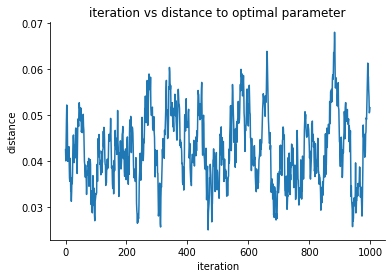

In [17]:
plot_dist_to_opt_param(klvi_param_history, klvi_var_param)

In [18]:
check_approx_accuracy(mf_gaussian_var_family, klvi_var_param, true_mean, true_cov, verbose=True);

mean   = [ 0.05479496 -0.09455725 -0.07659937 -0.48606879 -0.01804813  0.95497114
 -0.19969208  0.23707727  0.00912263  0.13256854  0.17524109  0.41084667
 -1.27140658  1.45740761]
stdevs = [0.02142814 0.00919941 0.07391125 0.11054225 0.03221199 0.02509421
 0.03762789 0.05127644 0.11096117 0.15660123 0.08889333 0.13315179
 0.276259   0.04430507]

mean error             = 2.83
stdev error            = 0.356
||cov error||_2^{1/2}  = 0.381
||true cov||_2^{1/2}   = 0.467


In [19]:
mc_samples = 1000000

samples, smoothed log weights, khat

In [20]:
klvi_samples, klvi_slw, klvi_khat = psis_correction(stan_log_density, mf_gaussian_var_family, klvi_var_param, mc_samples)

C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


In [21]:
print(klvi_khat)

1.0946851052257078


In [22]:
klvi_slw

array([-17.14970291, -19.29554535, -18.55722353, ..., -20.71726387,
       -16.28525681, -17.45610398])

## Mean field with t distribution (df=40)

In [23]:
mf_t_var_family = mean_field_t_variational_family(D+1, 40)
klvi_objective_and_grad = black_box_klvi(mf_t_var_family, stan_log_density, 100)

klvi_t_var_param, klvi_t_param_history, klvi_t_history, _ = \
    adagrad_optimize(n_iters, klvi_objective_and_grad, init_var_param, learning_rate=.01)

Average Loss = 537.05: 100%|██████████████████████████████████████████████████████| 4000/4000 [00:17<00:00, 228.23it/s]


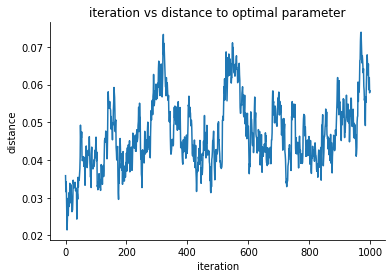

In [24]:
plot_dist_to_opt_param(klvi_t_param_history, klvi_t_var_param)

In [25]:
check_approx_accuracy(mf_t_var_family, klvi_t_var_param, true_mean, true_cov, verbose=True);

mean   = [ 0.05482369 -0.0945363  -0.07677745 -0.48609211 -0.01803252  0.95498498
 -0.19950477  0.23739842  0.00907599  0.13223101  0.17480737  0.41011523
 -1.27250798  1.45740975]
stdevs = [0.02153003 0.00925324 0.07406221 0.11035422 0.03265708 0.02517545
 0.03813403 0.05168736 0.11153688 0.15768927 0.08982339 0.13342655
 0.27882378 0.04414523]

mean error             = 2.83
stdev error            = 0.353
||cov error||_2^{1/2}  = 0.38
||true cov||_2^{1/2}   = 0.467


In [26]:
klvi_t_samples, klvi_t_slw, klvi_t_khat = \
    psis_correction(stan_log_density, mf_t_var_family, klvi_t_var_param, mc_samples)

In [27]:
print(klvi_t_khat)

1.0927024205868423


In [28]:
klvi_t_slw

array([-26.29609848, -20.19557557, -38.79349235, ..., -23.0372889 ,
       -16.56285024, -17.97763012])

# CHIVI

## Mean field with Gaussian

In [29]:
mf_gaussian_var_family = mean_field_gaussian_variational_family(D+1)
chivi_objective_and_grad = black_box_chivi(2, mf_gaussian_var_family, stan_log_density, 400)

# why did they do this?
init_var_param = klvi_var_param.copy()
init_var_param[2:] += 3

#init_mean = np.zeros(D+1)
#init_log_std = np.ones(D+1)
#init_var_param = np.concatenate([init_mean, init_log_std])
# n_iters = 5000

chivi_var_param, chivi_param_history, chivi_history, _ = \
    adagrad_optimize(n_iters, chivi_objective_and_grad, init_var_param, learning_rate=.01)

Average Loss = -3,376.9: 100%|█████████████████████████████████████████████████████| 4000/4000 [01:42<00:00, 39.20it/s]


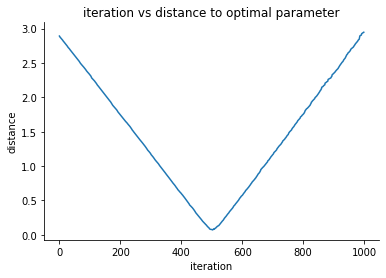

In [30]:
plot_dist_to_opt_param(chivi_param_history, chivi_var_param)

In [31]:
check_approx_accuracy(mf_gaussian_var_family, chivi_var_param, true_mean, true_cov, verbose=True);

mean   = [ 0.78683661  9.33911034  5.73709609  5.91184536  9.96880963 11.81321819
  9.33997831  8.91552046  6.73366843  5.61465864  7.36846506  6.6457997
  1.86823157  4.84547912]
stdevs = [2.81716593e-01 5.27662022e-02 7.42630665e-01 6.05011544e-01
 1.60616093e-01 1.26347109e-01 1.92613168e-01 2.55602599e-01
 5.35815984e-01 1.22995154e+00 4.13801002e-01 7.68532533e-01
 9.77322117e+02 6.74683447e+00]

mean error             = 26.9
stdev error            = 977
||cov error||_2^{1/2}  = 977
||true cov||_2^{1/2}   = 0.467


In [32]:
chivi_samples, chivi_slw, chivi_khat = psis_correction(stan_log_density, mf_gaussian_var_family, chivi_var_param, mc_samples)

C:\Users\Ben\Desktop\blackbox_scripts\psis.py:350: RuntimeWarning: overflow encountered in expm1
  np.expm1(x, out=x)


In [33]:
print(chivi_khat)

192.1167007499279


In [34]:
chivi_slw

array([-2.79940017e+05, -4.26494788e+04, -7.04692620e+11, ...,
       -1.11879821e+07, -1.93093238e+04, -7.03173024e+05])

## Mean field with t distribution (df=40)

In [35]:
mf_t_var_family = mean_field_t_variational_family(D+1, 40)
chivi_objective_and_grad = black_box_chivi(2, mf_t_var_family, stan_log_density, 400)

init_var_param = klvi_var_param.copy()
init_var_param[2:] += 3

chivi_t_var_param, chivi_t_param_history, chivi_t_history, _ = \
    adagrad_optimize(n_iters, chivi_objective_and_grad, init_var_param, learning_rate=.01)

Average Loss = -2,906: 100%|███████████████████████████████████████████████████████| 4000/4000 [01:32<00:00, 43.23it/s]


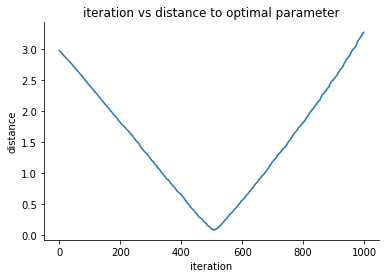

In [36]:
plot_dist_to_opt_param(chivi_t_param_history, chivi_t_var_param)

In [37]:
chivi_t_samples, chivi_t_slw, chivi_t_khat = \
    psis_correction(stan_log_density, mf_t_var_family, chivi_t_var_param, mc_samples)

In [38]:
print(chivi_t_khat)

99.79494821243442


In [39]:
chivi_t_slw

array([ -379857.31410657, -1272680.47121664,  -792546.54894496, ...,
        -842041.01849013,  -191079.59704286,   -47655.12552351])

# Non-mean field full-rank 

In [40]:
t_var_family = t_variational_family(D+1, 100)
full_klvi_objective_and_grad = black_box_klvi(t_var_family, stan_log_density, 100)

init_var_param = np.zeros(t_var_family.var_param_dim)

full_klvi_var_param, full_klvi_param_history, full_klvi_history, _ = \
    adagrad_optimize(n_iters, full_klvi_objective_and_grad, init_var_param, 
                     learning_rate=.1, learning_rate_end=.001)

Average Loss = 529.36: 100%|██████████████████████████████████████████████████████| 4000/4000 [00:24<00:00, 161.06it/s]


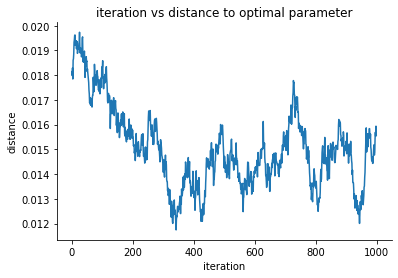

In [41]:
plot_dist_to_opt_param(full_klvi_param_history, full_klvi_var_param)

In [42]:
full_klvi_samples, full_klvi_slw, full_klvi_khat = \
    psis_correction(stan_log_density, t_var_family, full_klvi_var_param, mc_samples)

In [43]:
print(full_klvi_khat)

0.11584480118829898


In [44]:
full_klvi_slw

array([-13.76246915, -13.84182864, -13.86476834, ..., -13.73238751,
       -13.77397031, -14.23821483])

### CHIVI full rank

In [46]:
# t_var_family = t_variational_family(D+1, 100)
# full_chivi_objective_and_grad = black_box_chivi(2, t_var_family, stan_log_density, 400)

# init_var_param = full_klvi_var_param.copy()
# init_var_param[2:] += 3

# full_chivi_var_param, full_chivi_param_history, full_chivi_history, _ = \
#     adagrad_optimize(n_iters, full_chivi_objective_and_grad, init_var_param, 
#                      learning_rate=.1, learning_rate_end=.001)

In [47]:
#plot_dist_to_opt_param(full_chivi_param_history, full_chivi_var_param)

In [48]:
#full_chivi_samples, full_chivi_slw, full_chivi_khat = \
#    psis_correction(stan_log_density, t_var_family, full_chivi_var_param, mc_samples)

In [49]:
#print(full_chivi_khat)

In [ ]:
#full_chivi_slw